# Project 2: Student Dropout Classifier
*by Anna Kohnen & Marco Aigner*

In this project we develop and evaluate different models to identify students who are at risk of dropping out of university. 

## The Tasks
The project comprises 6 tasks, listed as follows:

1. To analyze and explore the dataset. To perform data pre-processing and cleansing.
2. To calculate and visualize the correlation of features among each other and with the labels. To discuss an intersting correlation
3. To train (at least) four machine-learning algorithms: One probabilistic, one tree-based, one distance-based and one ensemble method each.
4. To evaluate the models using k-fold cross-validation. To report accuracy, mean standard deviation and a confusion matrix per model. To discuss whether one model is significantly better than the others
5. To pick two favorite models. To discuss which features were most relevant for the students' success. To discuss differences between the two models
6. So export the best performing model as ONNX to compete against other models

## The Data
The dataset contains data from students from the Polytechnic Institute of Portalegre and was published by [Martins et al.](https://link.springer.com/chapter/10.1007/978-3-030-72657-7_16). It explicitly only includes information known at the time of students' enrollment and comprises features related to their academic path as well as to demographical and social-economic information.

There are both numerical and categorical features included in the dataset.

<div class="alert alert-block alert-info"> <b>Caution:</b> The categorical features are encoded as numbers.</div>

# Libraries
The following four libraries are allowed for this project:

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import numpy as np

# Importing the Data

In [122]:
student_data = pd.read_csv('./data/student_data.csv', delimiter=';')
student_data

,Marital status,Application mode,Application order,Course,Daytime/evening attendance\t,Previous qualification,Previous qualification (grade),Nacionality,Mother's qualification,Father's qualification,...,Curricular units 2nd sem (credited),Curricular units 2nd sem (enrolled),Curricular units 2nd sem (evaluations),Curricular units 2nd sem (approved),Curricular units 2nd sem (grade),Curricular units 2nd sem (without evaluations),Unemployment rate,Inflation rate,GDP,Target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4419,1,1,6,9773,1,1,125.0,1,1,1,...,0,6,8,5,12.666667,0,15.5,2.8,-4.06,Graduate
4420,1,1,2,9773,1,1,120.0,105,1,1,...,0,6,6,2,11.000000,0,11.1,0.6,2.02,Dropout
4421,1,1,1,9500,1,1,154.0,1,37,37,...,0,8,9,1,13.500000,0,13.9,-0.3,0.79,Dropout
4422,1,1,1,9147,1,1,180.0,1,37,37,...,0,5,6,5,12.000000,0,9.4,-0.8,-3.12,Graduate


In [123]:
train_data = pd.read_csv('./data/train.csv', delimiter=',')

In [124]:
test_data = pd.read_csv('./data/test.csv', delimiter=',')

# 1. Exploring and Pre-Processing
We first look at the data's shape:

In [125]:
student_data.shape

(4424, 37)

There is data on 4000 students across 37 columns each.

Taking a closer look at the columns:

In [ ]:
student_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4424 entries, 0 to 4423
Data columns (total 37 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Marital status                                  4424 non-null   int64  
 1   Application mode                                4424 non-null   int64  
 2   Application order                               4424 non-null   int64  
 3   Course                                          4424 non-null   int64  
 4   Daytime/evening attendance	                     4424 non-null   int64  
 5   Previous qualification                          4424 non-null   int64  
 6   Previous qualification (grade)                  4424 non-null   float64
 7   Nacionality                                     4424 non-null   int64  
 8   Mother's qualification                          4424 non-null   int64  
 9   Father's qualification                   

## 1.1 Pre-Processing
We can verify that **1.** there are 36 features and one target variable and **2.** that categorical features are numerically encoded.

For convenience and readabiltiy, we transform the column names into ```snake_case```

In [127]:
# create a list of new column names by replacing spaces and '/' with _ and removing the rest
snake_case_columns = student_data.columns.map(lambda x: x.lower().replace(' ', '_').replace('/','_').replace('(','').replace(')', '').replace('\t', '').replace('\'s','')).to_list()
student_data.rename(columns=dict(zip(student_data.columns, snake_case_columns)), inplace=True) # apply the snake_case column names
train_data.rename(columns=dict(zip(train_data.columns, snake_case_columns)), inplace=True) 
test_data.rename(columns=dict(zip(test_data.columns, snake_case_columns)), inplace=True) 

## 1.2 General Exploration
We fix a typo that we noticed:

In [129]:
student_data.rename(columns={'nacionality':'nationality'}, inplace=True)

train_data.rename(columns={'nacionality':'nationality'}, inplace=True)
test_data.rename(columns={'nacionality':'nationality'}, inplace=True)

Now let's inspect some rows of data:

In [ ]:
student_data.head()

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mother_qualification,father_qualification,...,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp,target
0,1,17,5,171,1,1,122.0,1,19,12,...,0,0,0,0,0.000000,0,10.8,1.4,1.74,Dropout
1,1,15,1,9254,1,1,160.0,1,1,3,...,0,6,6,6,13.666667,0,13.9,-0.3,0.79,Graduate
2,1,1,5,9070,1,1,122.0,1,37,37,...,0,6,0,0,0.000000,0,10.8,1.4,1.74,Dropout
3,1,17,2,9773,1,1,122.0,1,38,37,...,0,6,10,5,12.400000,0,9.4,-0.8,-3.12,Graduate
4,2,39,1,8014,0,1,100.0,1,37,38,...,0,6,6,6,13.000000,0,13.9,-0.3,0.79,Graduate


Are there any data missing?

In [112]:
student_data.isnull().values.any()

False

There seem to be no empty cells in the dataframe.

Are there duplicates within the data?

In [ ]:
student_data.isna().values.any()

False

In [32]:
print(accuracy_score(y_test, y_pred))

0.7625


There does not seem to be duplicate data present.

## 1.3 Statistical Exploration

Statistics might provide us further insight into the features.
We use different measures for continuous and categorical features.
We distinguish programmatically between the two by assigning the ``categorical`` dtype to categorical features.

We know that there are both continuous and discrete features within the dataset. Using the [documentation](https://archive.ics.uci.edu/dataset/697/predict+students+dropout+and+academic+success) we can manually extract a list of categorical columns: 

In [130]:
# manually create a list of categorical column names
categorical_columns = ['marital_status', 'application_mode', 'application_order', 'course', 'daytime_evening_attendance', 'previous_qualification', 'previous_qualification_grade', 'nationality', 'mother_qualification', 'father_qualification', 'mother_occupation', 'father_occupation', 'displaced', 'educational_special_needs', 'debtor', 'tuition_fees_up_to_date', 'gender', 'scholarship_holder', 'international']

# assign the categorical dtype to respective columns
student_data[categorical_columns] = student_data[categorical_columns].astype('category')

train_data[categorical_columns] = train_data[categorical_columns].astype('category')
test_data[categorical_columns] = test_data[categorical_columns].astype('category')

Pandas ``describe()``-method provides useful statistics such as the count, mean, minimum and maximum values as well as the standard deviation and percentiles of the distributions.

Now that we assigned categorical columns, the method summarizes only numerical features

In [78]:
student_data.describe()

,admission_grade,age_at_enrollment,curricular_units_1st_sem_credited,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_evaluations,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_credited,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_evaluations,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,unemployment_rate,inflation_rate,gdp
count,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000,4424.000000
mean,126.978119,23.265145,0.709991,6.270570,8.299051,4.706600,10.640822,0.137658,0.541817,6.232143,8.063291,4.435805,10.230206,0.150316,11.566139,1.228029,0.001969
std,14.482001,7.587816,2.360507,2.480178,4.179106,3.094238,4.843663,0.690880,1.918546,2.195951,3.947951,3.014764,5.210808,0.753774,2.663850,1.382711,2.269935
min,95.000000,17.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7.600000,-0.800000,-4.060000
25%,117.900000,19.000000,0.000000,5.000000,6.000000,3.000000,11.000000,0.000000,0.000000,5.000000,6.000000,2.000000,10.750000,0.000000,9.400000,0.300000,-1.700000
50%,126.100000,20.000000,0.000000,6.000000,8.000000,5.000000,12.285714,0.000000,0.000000,6.000000,8.000000,5.000000,12.200000,0.000000,11.100000,1.400000,0.320000
75%,134.800000,25.000000,0.000000,7.000000,10.000000,6.000000,13.400000,0.000000,0.000000,7.000000,10.000000,6.000000,13.333333,0.000000,13.900000,2.600000,1.790000
max,190.000000,70.000000,20.000000,26.000000,45.000000,26.000000,18.875000,12.000000,19.000000,23.000000,33.000000,20.000000,18.571429,12.000000,16.200000,3.700000,3.510000


Using ``describe`` on categorical columns gives us different statistics, such as the number of unique as well as the most frequent variable

In [79]:
student_data.describe(include=['category'])

,marital_status,application_mode,application_order,course,daytime_evening_attendance,previous_qualification,previous_qualification_grade,nationality,mother_qualification,father_qualification,mother_occupation,father_occupation,displaced,educational_special_needs,debtor,tuition_fees_up_to_date,gender,scholarship_holder,international
count,4424,4424,4424,4424,4424,4424,4424.0,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424,4424
unique,6,18,8,17,2,17,101.0,21,29,34,32,46,2,2,2,2,2,2,2
top,1,1,1,9500,1,1,133.1,1,1,37,9,9,1,0,0,1,0,0,0
freq,3919,1708,3026,766,3941,3717,491.0,4314,1069,1209,1577,1010,2426,4373,3921,3896,2868,3325,4314


## 1.4 Visual Exploration
### 1.4.1 Target Variables

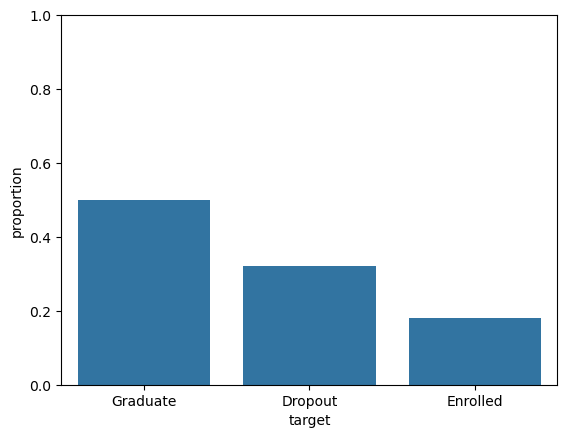

In [80]:
label_distribution = student_data.value_counts(subset=student_data['target'], normalize=True)

fig, ax = plt.subplots()
sns.barplot(data=label_distribution)
ax.set_ylim(0, 1)
plt.show()

### 1.4.2 Continuous Features
<div class="alert alert-block alert-danger">Ich glaube es macht Sinn zuerst die Korrelationen zu überprüfen bevor wir alle Features plotten. Dann können wir nämlich Features mit schwacher Korrelation zum Target raus schmeißen und sparen uns Arbeit beim plotten.</div>

# 2. Correlation Analysis

## 2.1 Features With The Target
We are interested in how much each feature correlates with the target. Features with a very low correlation likely do not provide significant information for our prognosis and therefore can be omitted. On the other hand, in our interpretation we can focus on highly correlated features instead.

First, we numerically encode the target column:

In [132]:
student_data['target'] = student_data['target'].map(arg={'Dropout':0, 'Enrolled':1, 'Graduate':2})

train_data['target'] = train_data['target'].map(arg={'Dropout':0, 'Enrolled':1, 'Graduate':2})
test_data['target'] = test_data['target'].map(arg={'Dropout':0, 'Enrolled':1, 'Graduate':2})


Then we calculate the pairwise correlations:

In [82]:
# TODO: try out different correlation methods (kendall, spearman, ...)
# However, spearman should be the way to go if we don't assume normal distributions
corr_feature_target = student_data.corrwith(other=student_data['target'], axis='index', drop=False, method='spearman')

corr_feature_target.sort_values(ascending=True)

age_at_enrollment                              -0.284946
debtor                                         -0.239002
gender                                         -0.229616
application_mode                               -0.214098
previous_qualification                         -0.125939
marital_status                                 -0.103578
curricular_units_2nd_sem_without_evaluations   -0.089313
curricular_units_1st_sem_without_evaluations   -0.081031
curricular_units_1st_sem_evaluations           -0.027602
inflation_rate                                 -0.022259
mother_qualification                           -0.018999
educational_special_needs                      -0.007953
nationality                                     0.002535
international                                   0.002860
course                                          0.014122
unemployment_rate                               0.016378
curricular_units_1st_sem_credited               0.019971
father_qualification           

- The correlation tell us how much each feature influences the target variable.
- Closer to 0 = less correlation with 0 = no  correlation
- Closer to 1/-1 more positive/negative correlation

We only focus on features that are highly correlated with the target. For this, we define a treshhold by which we filter:

In [83]:
CORRELATION_TRESHHOLD= 0.05

corr_feature_target = corr_feature_target[abs(corr_feature_target) >= CORRELATION_TRESHHOLD]
corr_feature_target.sort_values(ascending=True)

age_at_enrollment                              -0.284946
debtor                                         -0.239002
gender                                         -0.229616
application_mode                               -0.214098
previous_qualification                         -0.125939
marital_status                                 -0.103578
curricular_units_2nd_sem_without_evaluations   -0.089313
curricular_units_1st_sem_without_evaluations   -0.081031
gdp                                             0.053497
daytime_evening_attendance                      0.073066
application_order                               0.102185
previous_qualification_grade                    0.112414
displaced                                       0.113241
admission_grade                                 0.125791
curricular_units_1st_sem_enrolled               0.230576
curricular_units_2nd_sem_enrolled               0.241456
scholarship_holder                              0.301103
tuition_fees_up_to_date        

- Successfully reduced number of features
- TODO: Some interpretations of the correlations e.g. how lower age could lead to higher chances of graduation or how scholarship holders are more likely to graduate

## 2.2 Features With Each Other
- Multiple features with a high correlation among each other do not add information to the model
- Identify such groups of features
- Pick only the one with the highest correlation with the target

First calculate the correlation matrix using only the features with a high correlation with the target

In [84]:
df_corr_target = student_data[corr_feature_target.index]

correlations_features = df_corr_target.corr()

correlations_features

,marital_status,application_mode,application_order,daytime_evening_attendance,previous_qualification,previous_qualification_grade,admission_grade,displaced,debtor,tuition_fees_up_to_date,...,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,gdp,target
marital_status,1.000000,0.264006,-0.125854,-0.274939,0.062529,-0.022406,-0.004771,-0.234886,0.034304,-0.087158,...,0.052107,-0.031027,-0.059811,0.034711,0.039026,-0.043739,-0.071506,0.020426,-0.027003,-0.089804
application_mode,0.264006,1.000000,-0.286357,-0.304092,0.422411,-0.039020,-0.013271,-0.301197,0.122818,-0.136262,...,0.164299,-0.029055,-0.117741,0.045828,0.130046,-0.071526,-0.115424,0.047983,-0.022743,-0.221747
application_order,-0.125854,-0.286357,1.000000,0.158657,-0.184315,-0.064484,-0.096930,0.332362,-0.072151,0.055891,...,-0.016808,0.035580,0.058308,-0.031699,0.028878,0.071793,0.055517,-0.015757,0.030201,0.089791
daytime_evening_attendance,-0.274939,-0.304092,0.158657,1.000000,-0.071871,0.052597,0.007970,0.251767,0.006658,0.038799,...,-0.043056,0.016935,0.063974,0.045630,0.000371,0.034022,0.050493,-0.004229,0.022929,0.075107
previous_qualification,0.062529,0.422411,-0.184315,-0.071871,1.000000,0.104072,0.184183,-0.115188,0.095104,-0.068453,...,0.078702,0.022020,-0.000497,0.002887,0.056179,-0.008632,0.000942,0.005102,0.064069,-0.056039
previous_qualification_grade,-0.022406,-0.039020,-0.064484,0.052597,0.104072,1.000000,0.580444,-0.011001,-0.037507,0.060578,...,-0.029169,0.048410,0.059438,-0.003926,-0.031649,0.050263,0.053239,-0.019015,-0.052620,0.103764
admission_grade,-0.004771,-0.013271,-0.096930,0.007970,0.184183,0.580444,1.000000,-0.000543,-0.014423,0.054132,...,-0.033251,0.070892,0.073868,0.009033,-0.041878,0.076659,0.074402,-0.013254,-0.019519,0.120889
displaced,-0.234886,-0.301197,0.332362,0.251767,-0.115188,-0.011001,-0.000543,1.000000,-0.089901,0.096027,...,-0.063812,0.047682,0.064815,-0.021671,-0.041823,0.063698,0.069087,-0.035959,0.062875,0.113986
debtor,0.034304,0.122818,-0.072151,0.006658,0.095104,-0.037507,-0.014423,-0.089901,1.000000,-0.408454,...,-0.010652,-0.106657,-0.104170,0.001812,-0.029436,-0.146977,-0.139424,0.048552,0.075050,-0.240999
tuition_fees_up_to_date,-0.087158,-0.136262,0.055891,0.038799,-0.068453,0.060578,0.054132,0.096027,-0.408454,1.000000,...,0.058721,0.239347,0.250394,-0.049775,0.085918,0.291921,0.296480,-0.071817,-0.002768,0.409827


- Filter to only keep absolute correlations above a given treshhold 

In [85]:
correlations_features_filtered = correlations_features[abs(correlations_features) > 0.4]
correlations_features_filtered

,marital_status,application_mode,application_order,daytime_evening_attendance,previous_qualification,previous_qualification_grade,admission_grade,displaced,debtor,tuition_fees_up_to_date,...,curricular_units_1st_sem_enrolled,curricular_units_1st_sem_approved,curricular_units_1st_sem_grade,curricular_units_1st_sem_without_evaluations,curricular_units_2nd_sem_enrolled,curricular_units_2nd_sem_approved,curricular_units_2nd_sem_grade,curricular_units_2nd_sem_without_evaluations,gdp,target
marital_status,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_mode,NaN,1.000000,NaN,NaN,0.422411,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
application_order,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
daytime_evening_attendance,NaN,NaN,NaN,1.00000,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous_qualification,NaN,0.422411,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
previous_qualification_grade,NaN,NaN,NaN,NaN,NaN,1.000000,0.580444,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
admission_grade,NaN,NaN,NaN,NaN,NaN,0.580444,1.000000,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
displaced,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
debtor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000,-0.408454,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
tuition_fees_up_to_date,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.408454,1.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.409827


- Plot the remaining correlations

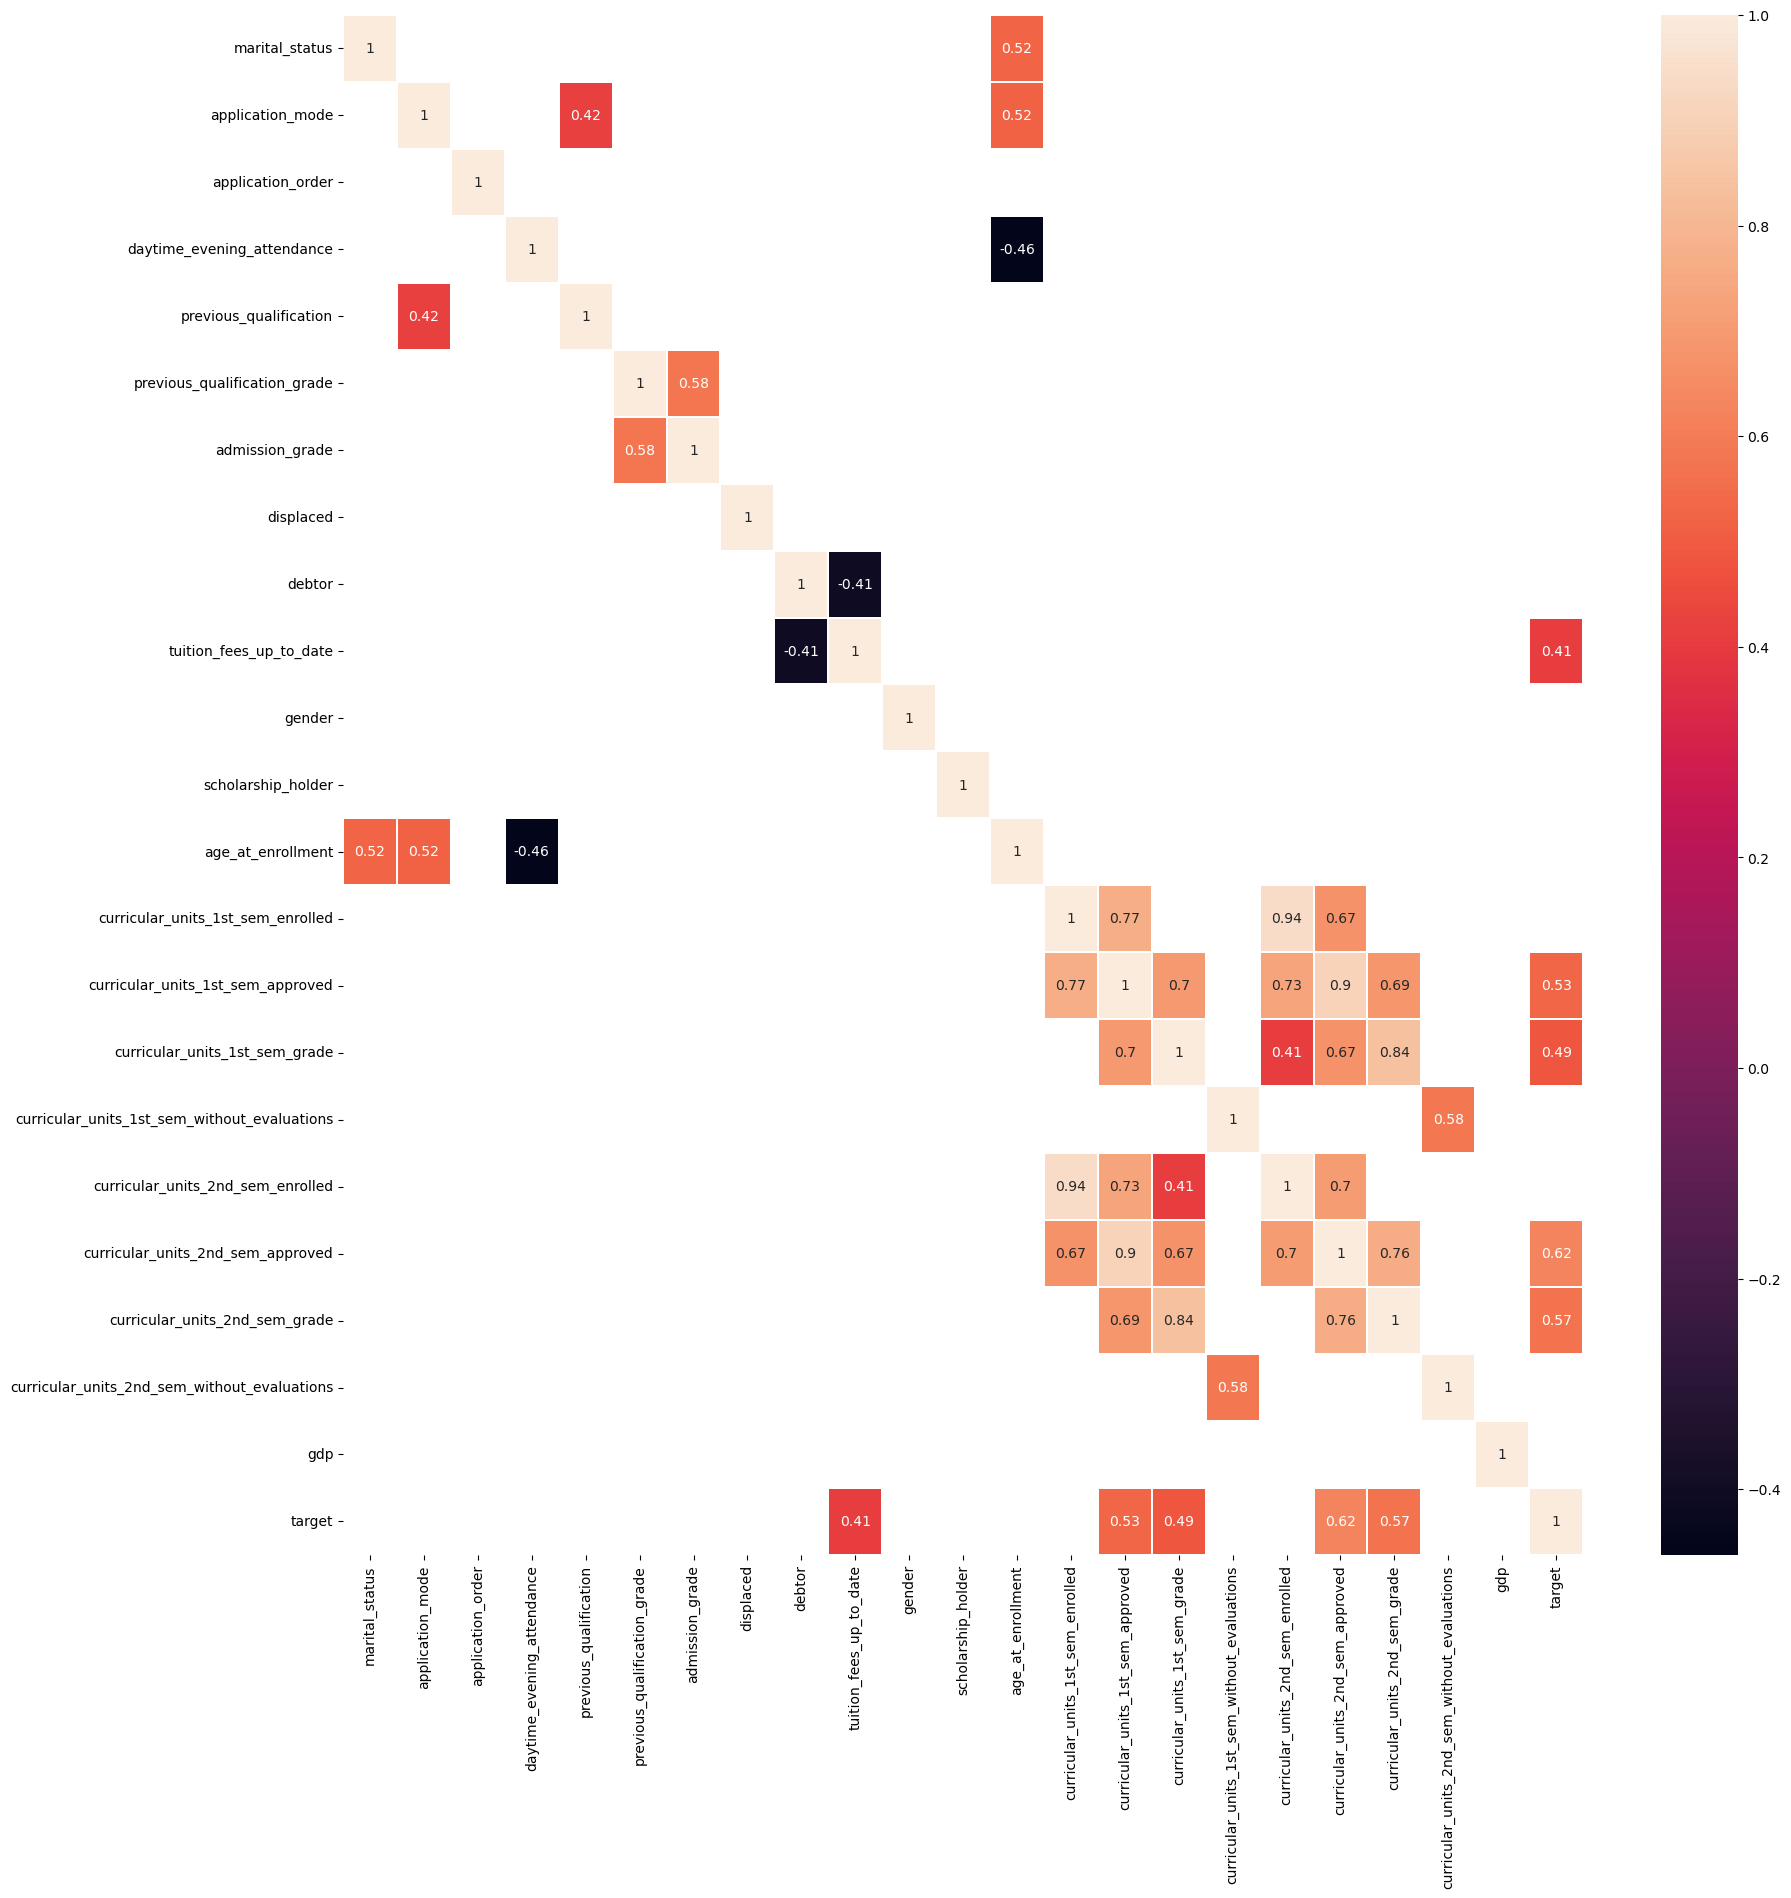

In [86]:
plt.figure(figsize=(20,20))
sns.heatmap(data=correlations_features_filtered, annot=True, linewidths=0.1)

plt.show()

- Discuss how the age at enrollment is correlated with the marital status, the application mode and daytime/evening-attendance

- Of a group of correlated features, only pick one (the one with the highest correlation with the target)

<div class="alert alert-block alert-info">Hardcoded for now. Maybe automate later</div>

In [87]:
#to_drop = ['marital_status', 'application_mode', 'daytime_evening_attendance', 'previous_qualification', 'previous_qualification_grade', 'debtor', 'curricular_units_1st_sem_enrolled', 'curricular_units_1st_sem_approved', 'curricular_units_1st_sem_grade', 'curricular_units_1st_sem_without_evaluations' ]

In [88]:
#final_dataframe = df_corr_target.drop(columns=to_drop, axis='columns')

#final_dataframe

# 3. Model Training

## 3.1 Data Split

In [40]:
final_dataframe = df_corr_target

In [41]:
from sklearn.model_selection import train_test_split

final_dataframe

X = final_dataframe.drop(columns='target')
y = final_dataframe['target']

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

<hr>

<hr>

# Create the models

<hr>

In [146]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import KFold, StratifiedKFold


# Probabilistic Model
probabilistic_model = GaussianNB()

# Tree-based Model
rfc = RandomForestClassifier(n_estimators=100, random_state=42)

# Distance-Based Model
knn = KNeighborsClassifier(n_neighbors=5)

# Ensemble Methods
gbc = GradientBoostingClassifier(n_estimators=100, random_state=42)
xgbc = XGBClassifier(objective='multi:softmax', num_class=3, random_state=42)

models = {
    'Gaussian Naive Bayes': GaussianNB(),

    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),

    'K-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),

    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42)
}

# Specify the number of folds for K-fold cross-validation
num_folds = 10

# Create KFold objects
folds = {
    'K-Fold' : KFold(n_splits=num_folds, shuffle=True, random_state=42),
    'Stratified K-Fold' : StratifiedKFold(n_splits=num_folds)
}



In scikit-learn, the KNeighborsClassifier expects the input data to be in the form of a NumPy array or array-like object, not a DataFrame.

This is why we call ".values" on our input data

<hr>

<hr>

# Method to train the model

In [139]:
def train_model(model, model_name, X_train, y_train):
    try:
        # Train the model
        model.fit(X_train.values, y_train.values)
    except Exception as e:
        print(f"Error while training {model_name}: {e}")

<hr>

<hr>

# Method for cross validation prediction

In [141]:
from sklearn.base import accuracy_score
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

def cross_validate_model(model, model_name, X, y, folding, fold_name):
    try:
        # Use cross_val_predict to get predictions for each fold
        y_pred = cross_val_predict(model, X.values, y.values, cv=folding)

        # Calculate confusion matrix
        cm = confusion_matrix(y, y_pred)
        #print(f"Confusion Matrix with {fold_name}:\n{cm}")

        # Calculate accuracy
        accuracy = accuracy_score(y, y_pred)
        print(f"{fold_name} with method cross_val_predict and model: {model_name} - Accuracy: {accuracy:.2f}\n")

        print(f"Classification Report with cross-val-predict for {model_name} and {fold_name} folding:\n")
        print(classification_report(y, y_pred) + "\n")

        return cm

    except Exception as e:
        print(f"Error while cross-validating {model_name}: {e}")
        return None

<hr>

<hr>

# Method to plot confusion Matrix

In [142]:
import seaborn as sns
import matplotlib.pyplot as plt


def plot_confusion_matrix(model_name, cm_dict):

    # Set the number of rows and columns for the subplots
    num_rows = 1
    num_cols = len(cm_dict)
    
    # Set the figure size
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5))

    # Flatten the axes if only one row
    axes = axes.flatten() if num_rows == 1 else axes

    # Iterate through the dictionary items and create subplots
    for idx, (title, matrix) in enumerate(cm_dict.items()):
        ax = axes[idx]
        sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
        ax.set_title(title)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('Actual')

    # Set the title for the entire plot
    plt.suptitle(model_name)
    
    # Adjust layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()



<hr>

<hr>

# Methode to get feature importance

In [143]:
def analyze_feature_importance(model, X):
    feature_importance = model.feature_importances_
    feature_dict = dict(zip(X.columns, feature_importance))

    # Sort the dictionary by values in ascending order
    sorted_dict = dict(sorted(feature_dict.items(), key=lambda item: item[1], reverse=True))
    print(sorted_dict)
    print("\n")

<hr>

<hr>

# Methode that does everything (fit, evaluate (cross-validation), feature importance, plot confusion matrix)

In [147]:
from sklearn.model_selection import cross_val_score

def train_and_evaluate_model(model, model_name, X, y, folding, fold_name):
    try:
        # Perform K-fold cross-validation and get accuracy scores for each fold
        cv_scores = cross_val_score(model, X.values, y.values, cv=folding, scoring='accuracy')
        print(f"{fold_name} with method cross_val_score and model: {model_name} - Accuracy: {np.mean(cv_scores):.2f} (± {np.std(cv_scores):.2f})\n")

        conf_mat = cross_validate_model(model, model_name, X, y, folding, fold_name)
        
        if conf_mat is not None:
            # Check if the model has feature_importances_ attribute
            if hasattr(model, 'feature_importances_'):
                analyze_feature_importance(model, X)
            else:
                print(f"Feature importance not available for {model_name} with {fold_name} folding." + "\n")

    except Exception as e:
        print(f"Error while processing {model_name}: {e}")
        
    return conf_mat

<hr>

<hr>

# Execute everything for each model

In [151]:

#TRAIN_FRACTION = 0.75
#train = pd.concat([final_dataframe[final_dataframe['target'] == 0].sample(frac=TRAIN_FRACTION), final_dataframe[final_dataframe['target'] == 1].sample(frac=TRAIN_FRACTION),final_dataframe[final_dataframe['target'] == 2].sample(frac=TRAIN_FRACTION)])
#test = final_dataframe.drop(train.index)
#X_train = test.drop(columns='target')
#y_train = test['target']
#X_test = test.drop(columns='target')
#y_test = test['target']
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTENC

X = train_data.drop(columns='target')
y = train_data['target']

sm = SMOTENC(random_state=42, categorical_features="auto")
X_res, y_res = sm.fit_resample(X, y)
y_res.shape

X_test = test_data.drop(columns='target')
y_test = test_data['target']
#X = final_dataframe.drop(columns='target')
#y = final_dataframe['target']

X_train,X_test,y_train,y_test = train_test_split(X_res,y_res,test_size=0.2,random_state=42)

X_train = train_data.drop(columns='target')
y_train = train_data['target']
# Loop through your models and call the train_and_evaluate_model method
for model_name, model in models.items():
    cm_dict = {}
    # Train the model
    train_model(model, model_name, X_train, y_train)

    for fold_name, fold in folds.items():
        cm_dict[fold_name] = train_and_evaluate_model(model, model_name, X_res, y_res, fold, fold_name)

    # Plot confusion matrix using seaborn
    plot_confusion_matrix(model_name, cm_dict)


    # Predict for Test-data
    y_pred = model.predict(X_test.values)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Prediction of test set with model: {model_name} - Accuracy: {accuracy:.2f}\n")


Prediction with model: Gaussian Naive Bayes - Accuracy: 0.57

Prediction with model: Random Forest - Accuracy: 0.90

Prediction with model: K-Nearest Neighbors - Accuracy: 0.65

Prediction with model: Gradient Boosting - Accuracy: 0.79

Prediction with model: XGBoost - Accuracy: 0.92



PCA, ein random feature nehmen, gini co efficient(rfc), multiple linear regression